# Rock Paper Scissor Transfer Learning with TensorFlow Hub for TFLite

In [1]:
# Import libraries 
import numpy as np
import matplotlib.pylab as plt

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

from tqdm import tqdm

# For matplotlib stability
import os    
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

In [2]:
# Import rock, paper, scissor dataset using tfds

(train_examples, validation_examples, test_examples), info = tfds.load('rock_paper_scissors', 
                                                                       with_info=True, 
                                                                       as_supervised=True, 
                                                                       split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'])

num_examples = info.splits['train'].num_examples
num_classes = info.features['label'].num_classes

In [3]:
# Check info for image size
info

tfds.core.DatasetInfo(
    name='rock_paper_scissors',
    full_name='rock_paper_scissors/3.0.0',
    description="""
    Images of hands playing rock, paper, scissor game.
    """,
    homepage='http://laurencemoroney.com/rock-paper-scissors-dataset',
    data_path='C:\\Users\\sumee\\tensorflow_datasets\\rock_paper_scissors\\3.0.0',
    file_format=tfrecord,
    download_size=219.53 MiB,
    dataset_size=219.23 MiB,
    features=FeaturesDict({
        'image': Image(shape=(300, 300, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=3),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'test': <SplitInfo num_examples=372, num_shards=1>,
        'train': <SplitInfo num_examples=2520, num_shards=2>,
    },
    citation="""@ONLINE {rps,
    author = "Laurence Moroney",
    title = "Rock, Paper, Scissors Dataset",
    month = "feb",
    year = "2019",
    url = "http://laurencemoroney.com/rock-paper-scissors-dat

In [4]:
# Using mobilenet_v2 for feature extraction
MODULE_HANDLE ="https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"
IMAGE_SIZE = (224, 224)
FV_SIZE = 1280
print("Using {} with input size {} and output dimension {}".format(MODULE_HANDLE, IMAGE_SIZE, FV_SIZE))

Using https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4 with input size (224, 224) and output dimension 1280


In [5]:
# Helper function to resize and nomalize images
def format_image(image, label):
    image = tf.image.resize(image, IMAGE_SIZE) / 255.0
    return  image, label

In [6]:
# PRepare the training, validation and test dataset

BATCH_SIZE = 32

train_batches = train_examples.shuffle(num_examples // 8).map(format_image).batch(BATCH_SIZE).prefetch(1)
validation_batches = validation_examples.map(format_image).batch(BATCH_SIZE).prefetch(1)
test_batches = test_examples.map(format_image).batch(1)

In [7]:
# Inspect a batch

for image_batch, label_batch in train_batches.take(1):
    pass

image_batch.shape

TensorShape([32, 224, 224, 3])

In [8]:
# Loading the mobilenet_v2 into feature_extractor and make it non-trainable

feature_extractor = hub.KerasLayer(MODULE_HANDLE,
                                   input_shape=IMAGE_SIZE + (3,), 
                                   output_shape=[FV_SIZE],
                                   trainable=False)


In [9]:
# Build sequential model with feature_extractor and one dense layer with three neurons for number of classses i.e. 
# rock, paper and sciccor

print("Building model with", MODULE_HANDLE)

model = tf.keras.Sequential([
        feature_extractor,
        tf.keras.layers.Dense(num_classes, activation='softmax')
])

model.summary()

Building model with https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              2257984   
                                                                 
 dense (Dense)               (None, 3)                 3843      
                                                                 
Total params: 2,261,827
Trainable params: 3,843
Non-trainable params: 2,257,984
_________________________________________________________________


In [10]:
# Compile the model
model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

In [11]:
# Train the model for five epochs

EPOCHS = 5

hist = model.fit(train_batches,
                 epochs=EPOCHS,
                 validation_data=validation_batches)

Epoch 1/5
63/63 [==============================] - 53s 806ms/step - loss: 0.3745 - accuracy: 0.9028 - val_loss: 0.1153 - val_accuracy: 0.9921
Epoch 2/5
63/63 [==============================] - 50s 787ms/step - loss: 0.0762 - accuracy: 0.9960 - val_loss: 0.0558 - val_accuracy: 0.9960
Epoch 3/5
63/63 [==============================] - 50s 800ms/step - loss: 0.0410 - accuracy: 0.9990 - val_loss: 0.0364 - val_accuracy: 1.0000
Epoch 4/5
63/63 [==============================] - 60s 961ms/step - loss: 0.0271 - accuracy: 1.0000 - val_loss: 0.0255 - val_accuracy: 1.0000
Epoch 5/5
63/63 [==============================] - 57s 907ms/step - loss: 0.0194 - accuracy: 1.0000 - val_loss: 0.0191 - val_accuracy: 1.0000


In [12]:
# Save the trained model

ROCK_PAPER_SCISSOR_SAVED_MODEL = "rps_saved_model"

tf.saved_model.save(model, ROCK_PAPER_SCISSOR_SAVED_MODEL)

INFO:tensorflow:Assets written to: rps_saved_model\assets


INFO:tensorflow:Assets written to: rps_saved_model\assets


In [13]:
# Convertion to tflite format

converter = tf.lite.TFLiteConverter.from_saved_model(ROCK_PAPER_SCISSOR_SAVED_MODEL)

# Post-Training Quantization

converter.optimizations = [tf.lite.Optimize.DEFAULT]

# Post-Training Integer Quantization

def representative_data_gen():
    for input_value, _ in test_batches.take(100):
        yield [input_value]
        
converter.representative_dataset = representative_data_gen

# Full Integer Quantization
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]

# Convert the saved model to tflite format and save

tflite_model = converter.convert()
tflite_model_file = 'rps.tflite'

with open(tflite_model_file, "wb") as f:
    f.write(tflite_model)

In [14]:
# Testing the tfite model using the tf.lite interpreter

# Load TFLite model and allocate tensors.
  
interpreter = tf.lite.Interpreter(model_path=tflite_model_file)
interpreter.allocate_tensors()

input_index = interpreter.get_input_details()[0]["index"]
output_index = interpreter.get_output_details()[0]["index"]

In [15]:
# Gather results for the randomly sampled test images
predictions = []

test_labels, test_imgs = [], []
for img, label in tqdm(test_batches.take(10)):
    interpreter.set_tensor(input_index, img)
    interpreter.invoke()
    predictions.append(interpreter.get_tensor(output_index))
    
    test_labels.append(label.numpy()[0])
    test_imgs.append(img)

100%|██████████| 10/10 [00:17<00:00,  1.69s/it]


In [16]:
#@title Utility functions for plotting
# Utilities for plotting

class_names = ['rock', 'paper', 'scissor']

def plot_image(i, predictions_array, true_label, img):
    predictions_array, true_label, img = predictions_array[i], true_label[i], img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    
    img = np.squeeze(img)

    plt.imshow(img, cmap=plt.cm.binary)
    
    predicted_label = np.argmax(predictions_array)
    
    if predicted_label == true_label:
        color = 'green'
    else:
        color = 'red'
    
    plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                         100*np.max(predictions_array),
                                         class_names[true_label]), color=color)

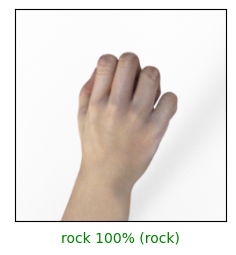

In [17]:
# Visualize the predictions; change the index between 0 and 9 
index = 1 
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(index, predictions, test_labels, test_imgs)
plt.show()